In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
from datetime import datetime, date, timedelta

import yfinance as yfin
from var import VaR
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns
#from yahoofinancials import YahooFinancials

#pd.set_option('display.float_format', '{:.10f}'.format)

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

# Assignment
Create a Github account if you do not already have one and download a VAR library.
Using the library that you have chosen and historical data (available from Yahoo Finance and other sources) calculate the VaR for your  investment portfolio.
Document your work in a presentation and post it to the Discussion Forum and comment on and discuss the document and posted work of others.

# Variables

In [2]:
start_date = datetime(2020, 1, 1)
end_date = datetime.now()
alpha = 0.05

yfin.pdr_override()

#start_date = "2022-01-01"
#end_date = "2023-08-31"
#alpha = 0.01

# Functions

# Load Data

folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w5/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })


folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker']).sum()
folio_df['Morningstar_Category'].fillna('Other', inplace=True)
folio_df.reset_index(inplace=True)
folio_df.drop(columns='ID', inplace=True)
folio_df

In [3]:
folio_df = pd.read_csv('./data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })


folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)
#folio_df['Morningstar_Category'].fillna('Other', inplace=True)
folio_df

,Ticker,BondName,Class,Shares,Value
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,"106,383.0000","1,000.0000"
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,"14,201.0000",500.0000
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,"49,967.0000",750.0000
3,C_A_S_H,Cash,Cash,"4,469,000.0000","4,469.0000"
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,"108,468.0000","2,250.0000"
...,...,...,...,...,...
30,VIGI,Vanguard Intl Div Apprec ETF,Economically Sensitive,"40,481.0000","3,000.0000"
31,VNQ,Vanguard Real Estate ETF,Economically Sensitive,"40,221.0000","3,250.0000"
32,VO,Vanguard Mid-Cap ETF,Economically Sensitive,"9,234.0000","2,000.0000"
33,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive,"41,501.0000","3,000.0000"


In [4]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,469.0000"
Economically Sensitive,"50,250.0000"
Interest Rate Sensitive,"29,000.0000"


## Calculate Percentage

In [5]:
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

In [6]:
ticker_lst = list(folio_df['Ticker'])
weights = (folio_df['port_percent'].values)

In [7]:
price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)
price_df = price_df[['Adj Close']]
price_df.columns = price_df.columns.get_level_values(1)
price_df['C_A_S_H'] = 1

price_df

[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No timezone found, symbol may be delisted')


,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2020-01-02,9.6599,26.7265,10.5664,1,NaN,24.2896,25.5028,...,19.0211,22.4164,64.4088,79.9387,168.9929,44.4435,49.6847
2020-01-03,9.6875,26.6375,10.5296,1,NaN,24.4753,25.4781,...,19.0925,22.5165,63.6910,80.4356,168.2368,44.1430,49.8609
2020-01-06,9.6875,26.7877,10.4745,1,NaN,24.5018,25.4676,...,19.0657,22.4892,63.8328,80.5315,168.4731,44.4047,49.8794
2020-01-07,9.6967,26.7932,10.4501,1,NaN,24.2101,25.4163,...,19.0390,22.4528,63.6821,79.6336,168.4258,44.3247,49.9443
2020-01-08,9.6967,26.8823,10.4562,1,NaN,24.2985,25.5768,...,19.0122,22.4164,64.1518,79.8777,168.7282,44.6495,49.9443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,9.2300,34.2600,15.0000,1,19.7800,23.0400,32.2600,...,18.2200,20.6100,72.2400,76.6245,209.5800,68.9900,48.3700
2023-09-26,9.2200,33.8200,14.8800,1,19.4100,22.6100,31.8900,...,18.2000,20.5800,71.4600,75.2281,206.6000,67.8600,48.3300
2023-09-27,9.2000,33.8100,14.8600,1,19.2600,22.4400,32.1000,...,18.1400,20.4800,71.3000,74.7230,207.2900,67.9600,48.2400


In [8]:
percent_df = price_df.pct_change()
percent_df = percent_df[1:]
percent_df.fillna(0, inplace=True)
percent_df.index = pd.to_datetime(percent_df.index)

percent_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2020-01-03,0.0029,-0.0033,-0.0035,0.0000,0.0000,0.0076,-0.0010,...,0.0038,0.0045,-0.0111,0.0062,-0.0045,-0.0068,0.0035
2020-01-06,0.0000,0.0056,-0.0052,0.0000,0.0000,0.0011,-0.0004,...,-0.0014,-0.0012,0.0022,0.0012,0.0014,0.0059,0.0004
2020-01-07,0.0010,0.0002,-0.0023,0.0000,0.0000,-0.0119,-0.0020,...,-0.0014,-0.0016,-0.0024,-0.0111,-0.0003,-0.0018,0.0013
2020-01-08,0.0000,0.0033,0.0006,0.0000,0.0000,0.0037,0.0063,...,-0.0014,-0.0016,0.0074,0.0031,0.0018,0.0073,0.0000
2020-01-09,0.0000,0.0091,0.0035,0.0000,0.0000,-0.0007,0.0013,...,0.0005,0.0012,0.0039,-0.0005,0.0064,0.0092,0.0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,-0.0065,-0.0003,0.0040,0.0000,-0.0010,-0.0009,0.0031,...,-0.0049,-0.0053,-0.0017,-0.0009,0.0027,0.0052,-0.0072
2023-09-26,-0.0011,-0.0128,-0.0080,0.0000,-0.0187,-0.0187,-0.0115,...,-0.0011,-0.0015,-0.0108,-0.0182,-0.0142,-0.0164,-0.0008
2023-09-27,-0.0022,-0.0003,-0.0013,0.0000,-0.0077,-0.0075,0.0066,...,-0.0033,-0.0049,-0.0022,-0.0067,0.0033,0.0015,-0.0019


In [9]:
price_df.query("index == '2023-09-11 00:00:00'")

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2023-09-11 00:00:00,9.4000,35.2100,15.0100,1,20.7436,24.2468,33.1387,...,18.3700,20.8500,74.1083,80.8038,216.5903,72.2877,49.1800


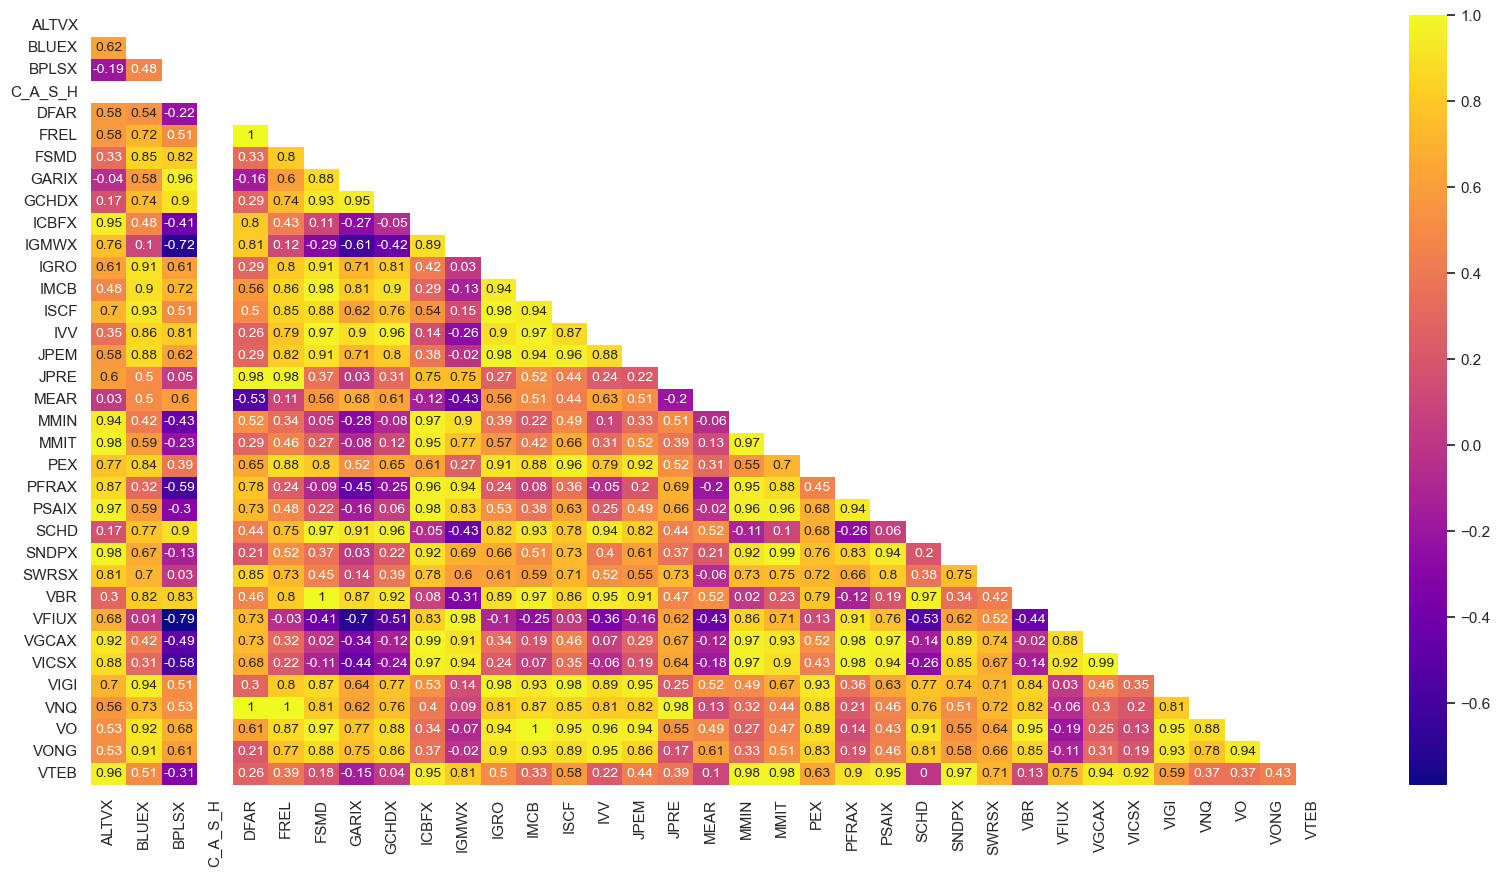

In [10]:
#t_df = df

plt.figure(figsize=(20,10))
mask = np.zeros_like(price_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(price_df.corr().round(2), annot=True, mask=mask, cmap="plasma", annot_kws={"size": 10})

# Calculate Portfolio Values

In [11]:
## Number of Shares

In [12]:
shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
shares_df[['Shares']].round(0)

,Shares
Ticker,
ALTVX,"106,383.0000"
BLUEX,"14,201.0000"
BPLSX,"49,967.0000"
C_A_S_H,"4,469,000.0000"
DFAR,"108,468.0000"
...,...
VIGI,"40,481.0000"
VNQ,"40,221.0000"
VO,"9,234.0000"


## Prices Timeseries

In [13]:
price_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2020-01-02,9.6599,26.7265,10.5664,1,NaN,24.2896,25.5028,...,19.0211,22.4164,64.4088,79.9387,168.9929,44.4435,49.6847
2020-01-03,9.6875,26.6375,10.5296,1,NaN,24.4753,25.4781,...,19.0925,22.5165,63.6910,80.4356,168.2368,44.1430,49.8609
2020-01-06,9.6875,26.7877,10.4745,1,NaN,24.5018,25.4676,...,19.0657,22.4892,63.8328,80.5315,168.4731,44.4047,49.8794
2020-01-07,9.6967,26.7932,10.4501,1,NaN,24.2101,25.4163,...,19.0390,22.4528,63.6821,79.6336,168.4258,44.3247,49.9443
2020-01-08,9.6967,26.8823,10.4562,1,NaN,24.2985,25.5768,...,19.0122,22.4164,64.1518,79.8777,168.7282,44.6495,49.9443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-25,9.2300,34.2600,15.0000,1,19.7800,23.0400,32.2600,...,18.2200,20.6100,72.2400,76.6245,209.5800,68.9900,48.3700
2023-09-26,9.2200,33.8200,14.8800,1,19.4100,22.6100,31.8900,...,18.2000,20.5800,71.4600,75.2281,206.6000,67.8600,48.3300
2023-09-27,9.2000,33.8100,14.8600,1,19.2600,22.4400,32.1000,...,18.1400,20.4800,71.3000,74.7230,207.2900,67.9600,48.2400


In [14]:
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df

,Date,Ticker,Price
0,2020-01-02,ALTVX,9.6599
1,2020-01-03,ALTVX,9.6875
2,2020-01-06,ALTVX,9.6875
3,2020-01-07,ALTVX,9.6967
4,2020-01-08,ALTVX,9.6967
...,...,...,...
33000,2023-09-25,VTEB,48.3700
33001,2023-09-26,VTEB,48.3300
33002,2023-09-27,VTEB,48.2400
33003,2023-09-28,VTEB,48.0300


## Add Asset Classes

In [15]:
l_df = folio_df[['Ticker','Class']] #.drop_duplicates() 
l_df

,Ticker,Class
0,ALTVX,Interest Rate Sensitive
1,BLUEX,Economically Sensitive
2,BPLSX,Economically Sensitive
3,C_A_S_H,Cash
4,DFAR,Economically Sensitive
...,...,...
30,VIGI,Economically Sensitive
31,VNQ,Economically Sensitive
32,VO,Economically Sensitive
33,VONG,Economically Sensitive


## Calculate Asset Value Overtime

In [16]:
merg_df = m_df.merge(l_df, how='left', left_on='Ticker', right_on='Ticker').merge(shares_df,how='left' ,left_on='Ticker', right_on='Ticker')
merg_df['share_value'] = merg_df['Price'] * merg_df['Shares']
merg_df

,Date,Ticker,Price,Class,Shares,share_value
0,2020-01-02,ALTVX,9.6599,Interest Rate Sensitive,"106,383.0000","1,027,645.3572"
1,2020-01-03,ALTVX,9.6875,Interest Rate Sensitive,"106,383.0000","1,030,583.8921"
2,2020-01-06,ALTVX,9.6875,Interest Rate Sensitive,"106,383.0000","1,030,583.8921"
3,2020-01-07,ALTVX,9.6967,Interest Rate Sensitive,"106,383.0000","1,031,563.5391"
4,2020-01-08,ALTVX,9.6967,Interest Rate Sensitive,"106,383.0000","1,031,563.5391"
...,...,...,...,...,...,...
33000,2023-09-25,VTEB,48.3700,Interest Rate Sensitive,"20,333.0000","983,507.1883"
33001,2023-09-26,VTEB,48.3300,Interest Rate Sensitive,"20,333.0000","982,693.9272"
33002,2023-09-27,VTEB,48.2400,Interest Rate Sensitive,"20,333.0000","980,863.9541"
33003,2023-09-28,VTEB,48.0300,Interest Rate Sensitive,"20,333.0000","976,593.9652"


In [17]:
t_df = merg_df.groupby(['Date','Class'])[['share_value']].sum().reset_index()
t_df

,Date,Class,share_value
0,2020-01-02,Cash,"4,469,000.0000"
1,2020-01-02,Economically Sensitive,"38,298,748.3084"
2,2020-01-02,Interest Rate Sensitive,"30,120,933.7059"
3,2020-01-03,Cash,"4,469,000.0000"
4,2020-01-03,Economically Sensitive,"38,125,693.7082"
...,...,...,...
2824,2023-09-28,Economically Sensitive,"48,229,242.3354"
2825,2023-09-28,Interest Rate Sensitive,"28,546,307.5982"
2826,2023-09-29,Cash,"4,469,000.0000"
2827,2023-09-29,Economically Sensitive,"48,193,309.1122"


In [18]:
t_df[t_df['Date'] == '2023-09-11']

,Date,Class,share_value
2784,2023-09-11,Cash,"4,469,000.0000"
2785,2023-09-11,Economically Sensitive,"50,250,088.6926"
2786,2023-09-11,Interest Rate Sensitive,"28,999,975.7671"


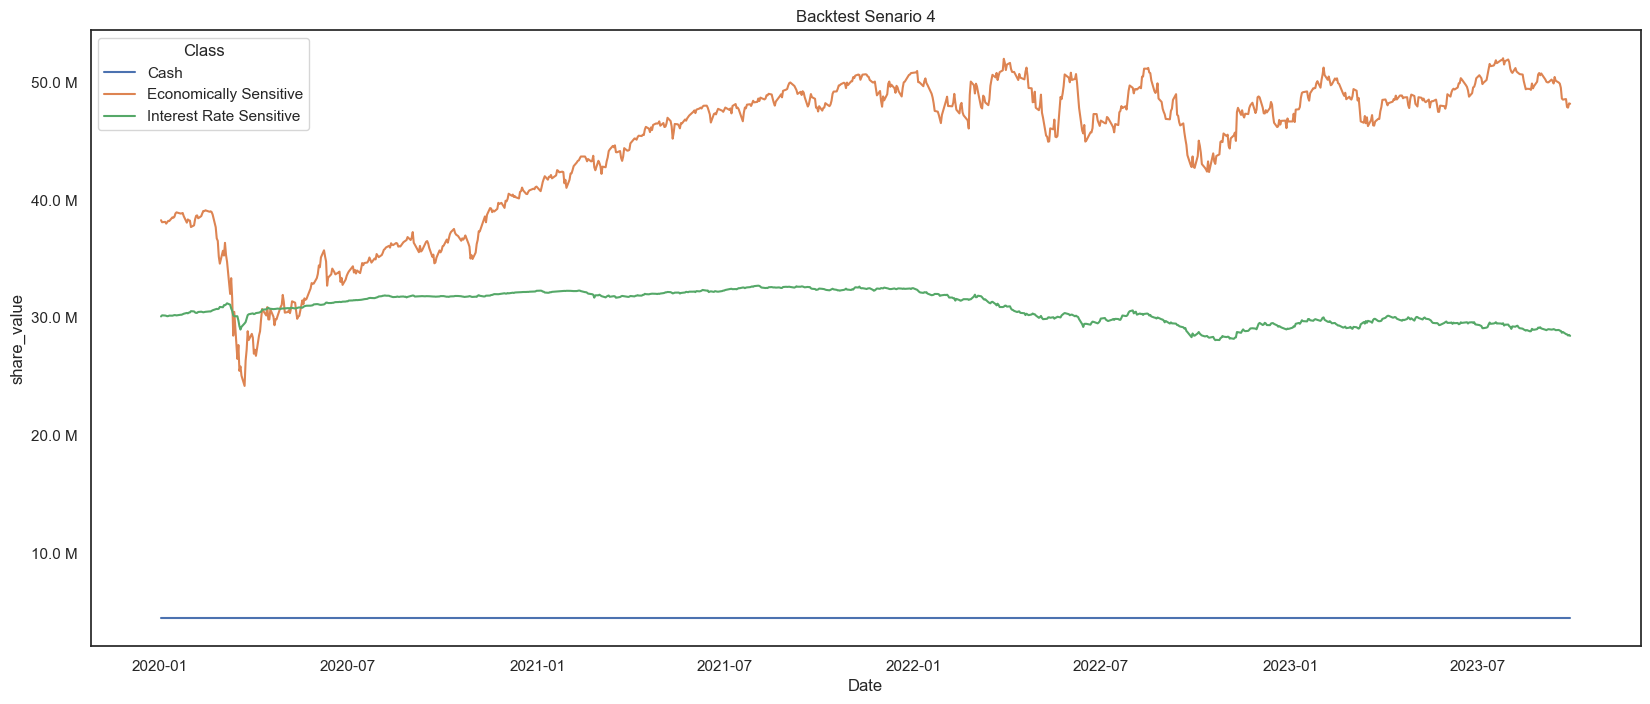

In [19]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
plt.ticklabel_format(style='plain', axis='y')

# Plot
sns.set_style("white")
g = sns.lineplot(data=t_df, x="Date", y="share_value", hue='Class')
g.set_yticklabels(['{:,.1f}'.format(x) + ' M' for x in g.get_yticks()/1000000])

ax.set(title='Backtest Senario 4');

## Asset Class Correlation

In [20]:
s_df = t_df.copy()
s_df = s_df.pivot(index='Date', columns='Class', values='share_value')

s_df

Class,Cash,Economically Sensitive,Interest Rate Sensitive
Date,,,
2020-01-02,"4,469,000.0000","38,298,748.3084","30,120,933.7059"
2020-01-03,"4,469,000.0000","38,125,693.7082","30,212,485.0748"
2020-01-06,"4,469,000.0000","38,157,893.8575","30,195,998.7559"
2020-01-07,"4,469,000.0000","38,008,273.9374","30,173,275.7812"
2020-01-08,"4,469,000.0000","38,131,475.0161","30,138,862.4550"
...,...,...,...
2023-09-25,"4,469,000.0000","48,594,635.3662","28,619,242.2175"
2023-09-26,"4,469,000.0000","47,913,704.2044","28,593,708.2587"
2023-09-27,"4,469,000.0000","47,864,633.1783","28,502,372.2289"


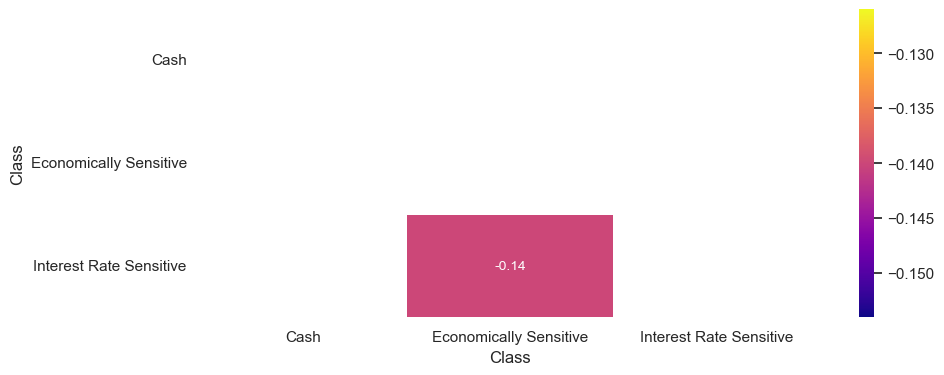

In [21]:
plt.figure(figsize=(10,4))
mask = np.zeros_like(s_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(s_df.corr().round(2), annot=True, mask=mask, cmap="plasma", annot_kws={"size": 10})

# Calculate VaR

In [22]:
l2 = list(folio_df['Ticker'])
l1 = percent_df.columns
list_dif = set(l2).symmetric_difference(set(l1))


print('l1: ', len(l1), 'l2: ', len(l2), 'dif: ', list_dif)

l1:  35 l2:  35 dif:  set()


In [23]:
var = VaR(percent_df, weights, alpha=[0.05,0.025,0.01])
#var = VaR(percent_df, weights, alpha=0.05)
var

<VaR - μ: 0.01%, σ: 0.8075%, Portfolio σ: 0.8079%>

In [24]:
var.info

{'Daily Mean PnL': 0.00012114635159283552,
 'Daily Volatility': 0.008074605166716394,
 'Portfolio Volatility': 0.008078894465912248}

In [25]:
var.historic()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-29,-0.0118,-0.0148,-0.0200,-0.0193,-0.0255,-0.0381,-0.1743,-0.1872,-0.1998


In [26]:
print('VaR(95.0):', var.historic()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.historic()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -1.1803873965130363
Portfolio VaR(95.0) -988208.5244867489


In [27]:
var.parametric()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-29,-0.0265,-0.0280,-0.0299,-0.0423,-0.0446,-0.0472,-0.1743,-0.1872,-0.1998


In [28]:
print('VaR(95.0):', var.parametric()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.parametric()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -2.6462671849393344
Portfolio VaR(95.0) -2215428.4245593613


In [29]:
var.monte_carlo()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-29,-0.0132,-0.0159,-0.0187,-0.0166,-0.0188,-0.0214,-0.1743,-0.1872,-0.1998


In [30]:
print('VaR(95.0):', var.monte_carlo()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.monte_carlo()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -1.3170002025359349
Portfolio VaR(95.0) -1105694.7990427783


In [31]:
var.monte_carlo(stressed=True)

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-09-29,-0.0304,-0.0338,-0.0374,-0.0347,-0.0375,-0.0405,-0.7426,-0.7462,-0.7497


# Backtest

In [32]:
bth = var.backtest(method='h')

Backtest: Historic Method: 100%|██████████| 692/692 [00:00<00:00, 987.77it/s] 


In [33]:
var.evaluate(bth)

,Amount,Percent,Mean Deviation,STD Deviation,Min Deviation,Max Deviation
Observations,692,1,0,0,0,0
VaR(95.0),34,0.0491,-0.0035,0.0031,-0.0000,-0.0153
VaR(99.0),10,0.0145,-0.0066,0.0036,-0.0029,-0.0153
CVaR(95.0),17,0.0246,-0.0031,0.0029,-0.0002,-0.0123
CVaR(99.0),6,0.0087,-0.0059,0.0034,-0.0035,-0.0123
CDaR(95.0),1,0.0014,-0.0056,0.0000,-0.0056,-0.0056
CDaR(99.0),0,0.0000,NaN,NaN,NaN,NaN


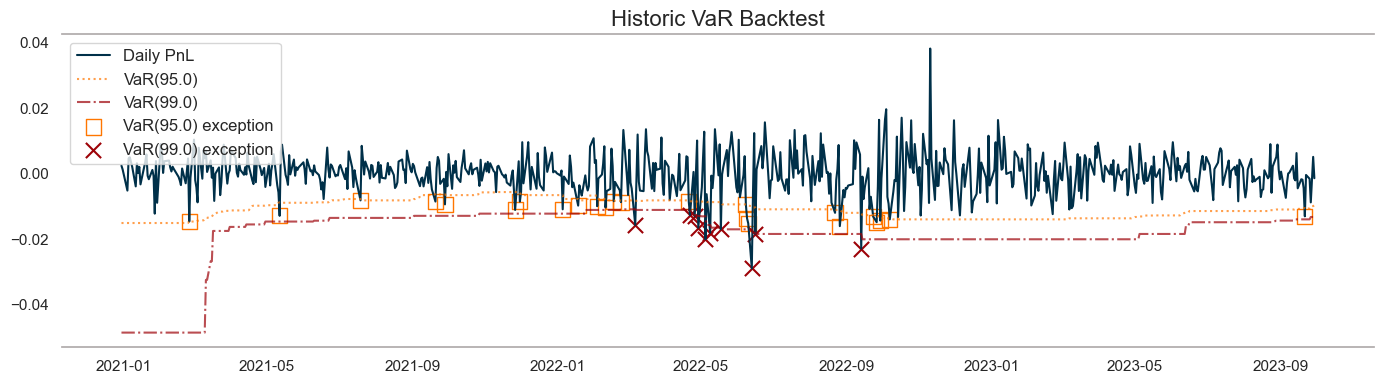

In [34]:
var.var_plot(bth)

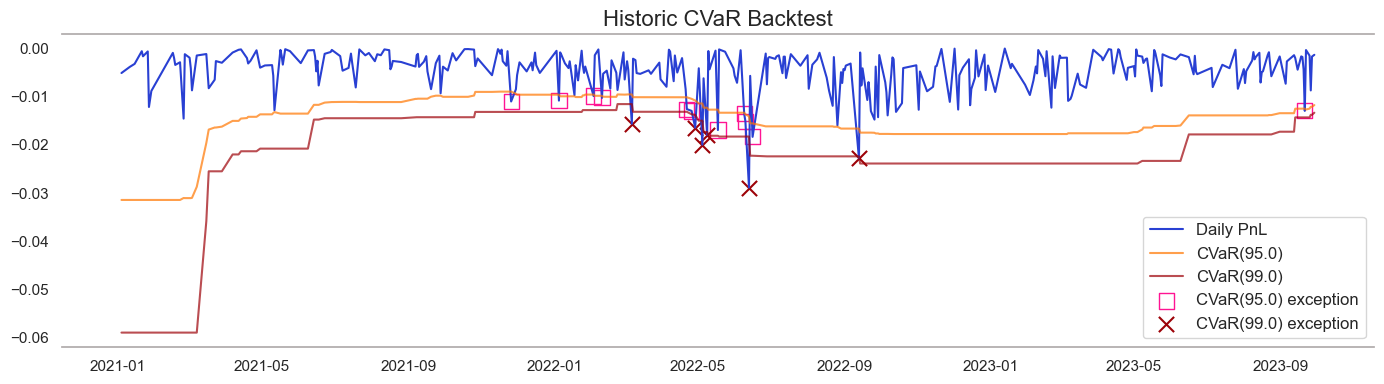

In [35]:
var.cvar_plot(bth)

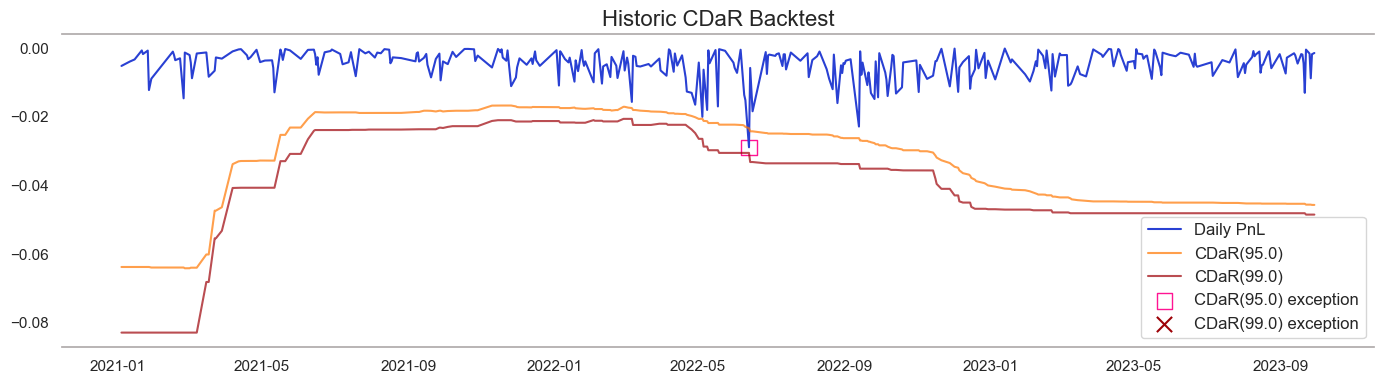

In [36]:
var.cdar_plot(bth)